In [1]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

In [54]:
n_trials = 100
data_4 =  list(np.random.binomial(1,0.75,n_trials//4)) + list(np.random.binomial(1,0.1,n_trials//4)) + list(np.random.binomial(1,0.9,n_trials//4))+ list(np.random.binomial(1,0.5,n_trials//4))
data_2 =  list(np.random.binomial(1,0.75,n_trials//2)) +  list(np.random.binomial(1,0.25,n_trials//2))
data_1 = list(np.random.binomial(1,0.75,n_trials))

In [4]:
x = np.linspace(0, 1, 1000)

## Markov - volatility change detection

state-transition proba = volatility = v/K

state-consistency-proba = 1-v

prior = markov

likelihood = beta-model



In [16]:
def simple_vol_change_detection(data, v = 0.1, display=False):
    if display:
        plt.figure(figsize=(30,100))
    
    beta_ = {}
    count = {}
    mem_choice = []
    mem_q = []
    lik = {}
    diri = {}
    n = 0
    K = 0
    choice = 0
    for i, obs in enumerate(data):
        z = 0
        for k in range(K):
            diri[k] = 1
            q = beta.rvs(beta_[k][1], beta_[k][0])
            lik[k] = q * obs + (1-q) * (1-obs)
            if choice == k:
                z += (1 - v) * diri[k] * lik[k]
            else:
                z += v / (K+1) * diri[k] * lik[k]
        diri[K] = 1
        q = beta.rvs(1, 1)
        lik[K] = q * obs + (1-q) * (1-obs)
        if choice == K:
            z += (1 - v) * diri[K] * lik[K]
        else:
            z += v / (K+1) * diri[K] * lik[K]
        p = np.zeros(K+1)
        for k in range(K+1):
            if choice == k:
                p[k] = (1 - v) * diri[k] * lik[k] / z
            else:
                p[k] = v / (K+1) * diri[k] * lik[k] / z
        #print(p)
        choice = np.random.choice(list(range(K+1)), p=p)
        mem_choice += [choice]
        if choice == K:
            K += 1
            beta_[choice] = {0:1, 1:1}
            count[choice] = 0               
        count[choice] += 1
        beta_[choice][obs] += 1
        mem_q +=  [beta.mean(beta_[choice][1], beta_[choice][0])]
        n += 1
             
        if display:
            ax = plt.subplot(25,5,i+1)

            #print(p, choice)
            for k in range(K):
                pdf = beta.pdf(x, beta_[k][1], beta_[k][0])
                ax.plot(x, pdf, label=f'{k}')
            ax.set_title(f'Observation #{i+1}')#, overlap={overlap_prob:.2f}')
            ax.text(0.05,4.5,f'obs={obs}')
            ax.text(0.05,4.1,f'Choice={choice}')
            ax.set_ylim(0,5)
            ax.set_xlim(0,1)
            plt.legend(loc=1)
    return beta_, count, mem_choice, mem_q

In [77]:
def vol_dirichlet_change_detection(data, alpha=15, v = 0.2, count_max = 30, display=False):
    if display:
        plt.figure(figsize=(30,100))
    
    beta_ = {}
    count = {}
    mem_choice = []
    mem_q = []
    lik = {}
    diri = {}
    n = 0
    K = 0
    choice = 0
    for i, obs in enumerate(data):
        z = 0
        for k in range(K):
            diri[k] = count[k] / (n + alpha)
            #q = beta.rvs(beta_[k][1], beta_[k][0])
            q = beta.mean(beta_[k][1], beta_[k][0])
            lik[k] = q * obs + (1-q) * (1-obs)
            if choice == k:
                z += (1 - v) * diri[k] * lik[k]
            else:
                z += v / (K+1) * diri[k] * lik[k]
        diri[K] = alpha / (n + alpha)
        #q = beta.rvs(1,1)
        q = beta.mean(1,1)
        lik[K] = q * obs + (1-q) * (1-obs)
        if choice == K:
            z += (1 - v) * diri[K] * lik[K]
        else:
            z += v / (K+1) * diri[K] * lik[K]
        p = np.zeros(K+1)
        for k in range(K+1):
            if choice == k:
                p[k] = (1 - v) * diri[k] * lik[k] / z
            else:
                p[k] = v / (K+1) * diri[k] * lik[k] / z
        #print(p)
        choice = np.random.choice(list(range(K+1)), p=p)
        mem_choice += [choice]
        if choice == K:
            K += 1
            beta_[choice] = {0:1, 1:1}
            count[choice] = 0      
        count[choice] += 1
        count[choice] = min(count[choice], count_max)
        beta_[choice][obs] += 1
        mem_q +=  [beta.mean(beta_[choice][1], beta_[choice][0])]
        n = np.sum(choice)
             
        if display:
            ax = plt.subplot(25,5,i+1)
        
            #print(p, choice)
            for k in range(K):
                pdf = beta.pdf(x, beta_[k][1], beta_[k][0])
                ax.plot(x, pdf, label=f'{k}')
            ax.set_title(f'Observation #{i+1}')#, overlap={overlap_prob:.2f}')
            ax.text(0.05,4.5,f'obs={obs}')
            ax.text(0.05,4.1,f'Choice={choice}')
            ax.set_ylim(0,5)
            ax.set_xlim(0,1)
            plt.legend(loc=1)
    return beta_, count, mem_choice, mem_q

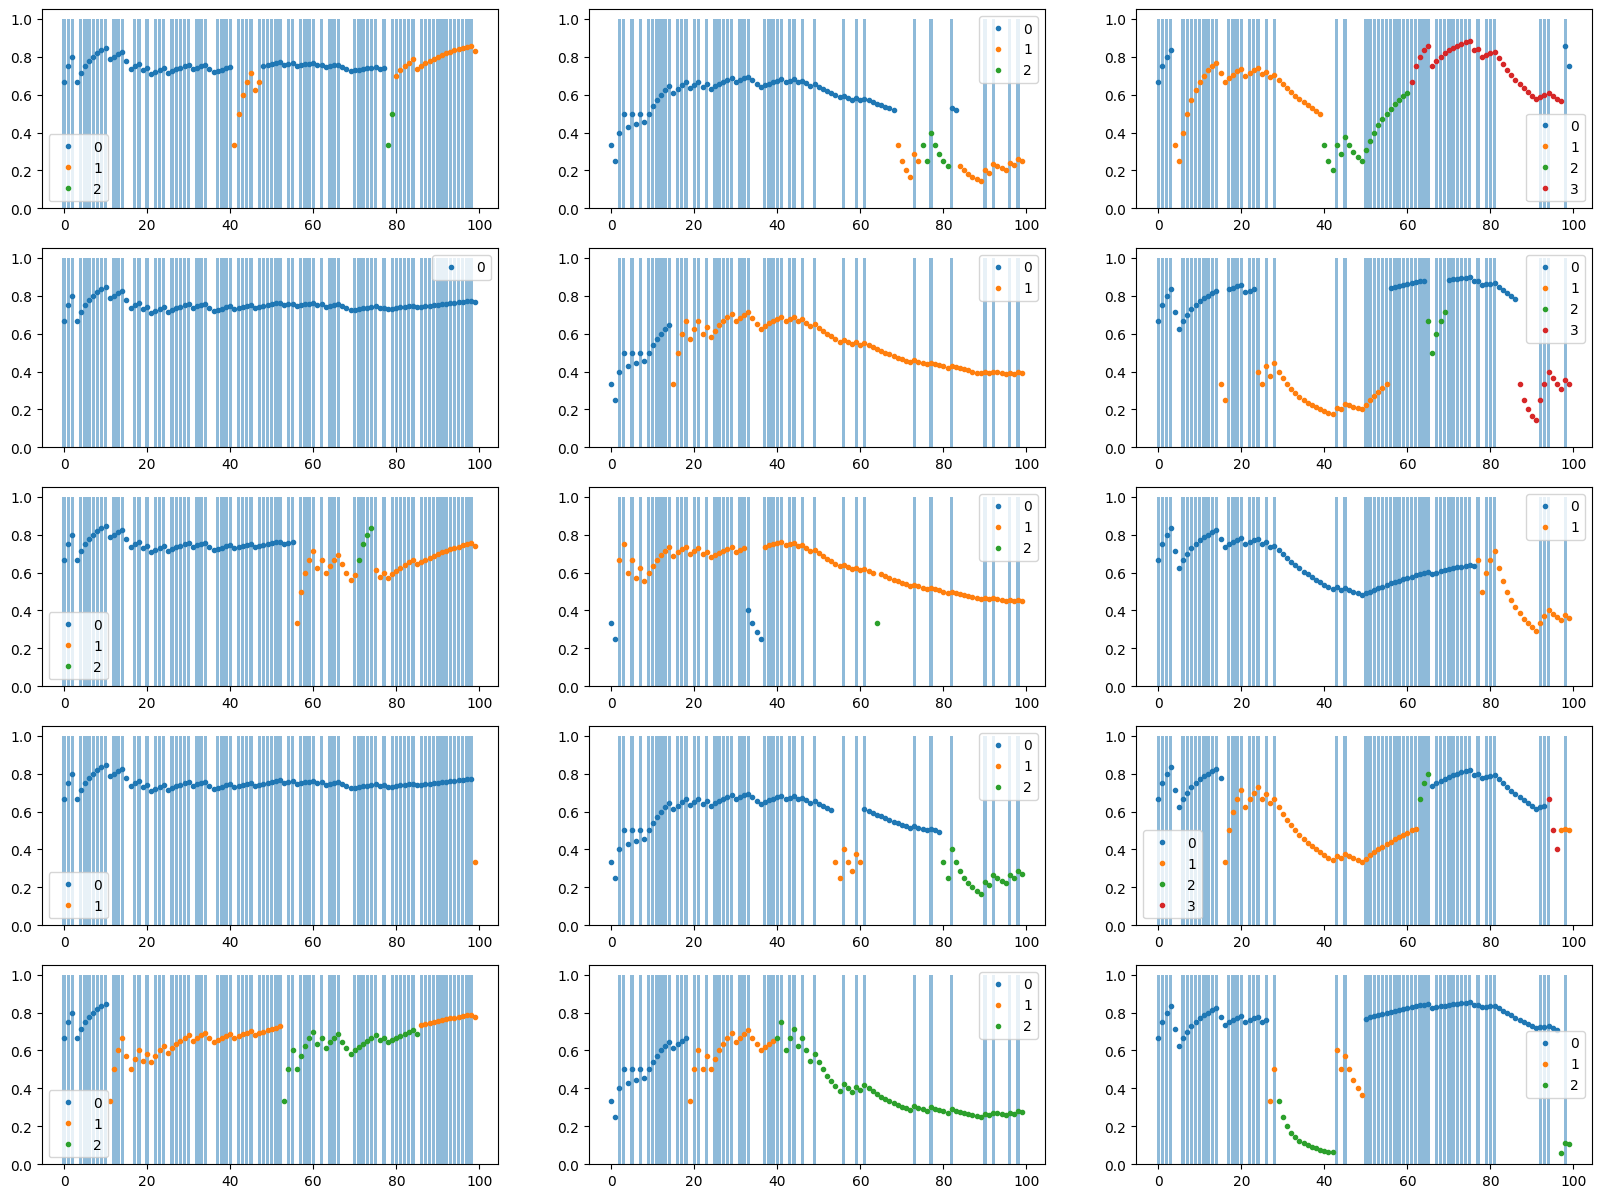

In [35]:
repeat = 5
plt.figure(figsize=(20,3 * repeat))

for r in range(repeat):
    for i, data in enumerate((data_1, data_2, data_4)):
    
        beta_, count, mem_choice, mem_q = simple_vol_change_detection(data, v=0.05)
    
        ax = plt.subplot(repeat, 3, 3*r+i+1)
        ax.bar(range(len(data)),data, alpha=.5)
        for k in range(len(beta_)):
            axe = np.where(np.array(mem_choice) == k)[0]
            plt.plot(axe, np.array(mem_q)[axe],'.', label=k)
            '''plt.plot([0,24],[.75,.75],'r:')
            plt.plot([25,49],[.25,.25],'r:')
            plt.plot([50,74],[.9,.9],'r:')
            plt.plot([75,99],[.5,.5],'r:')'''
        ax.legend()

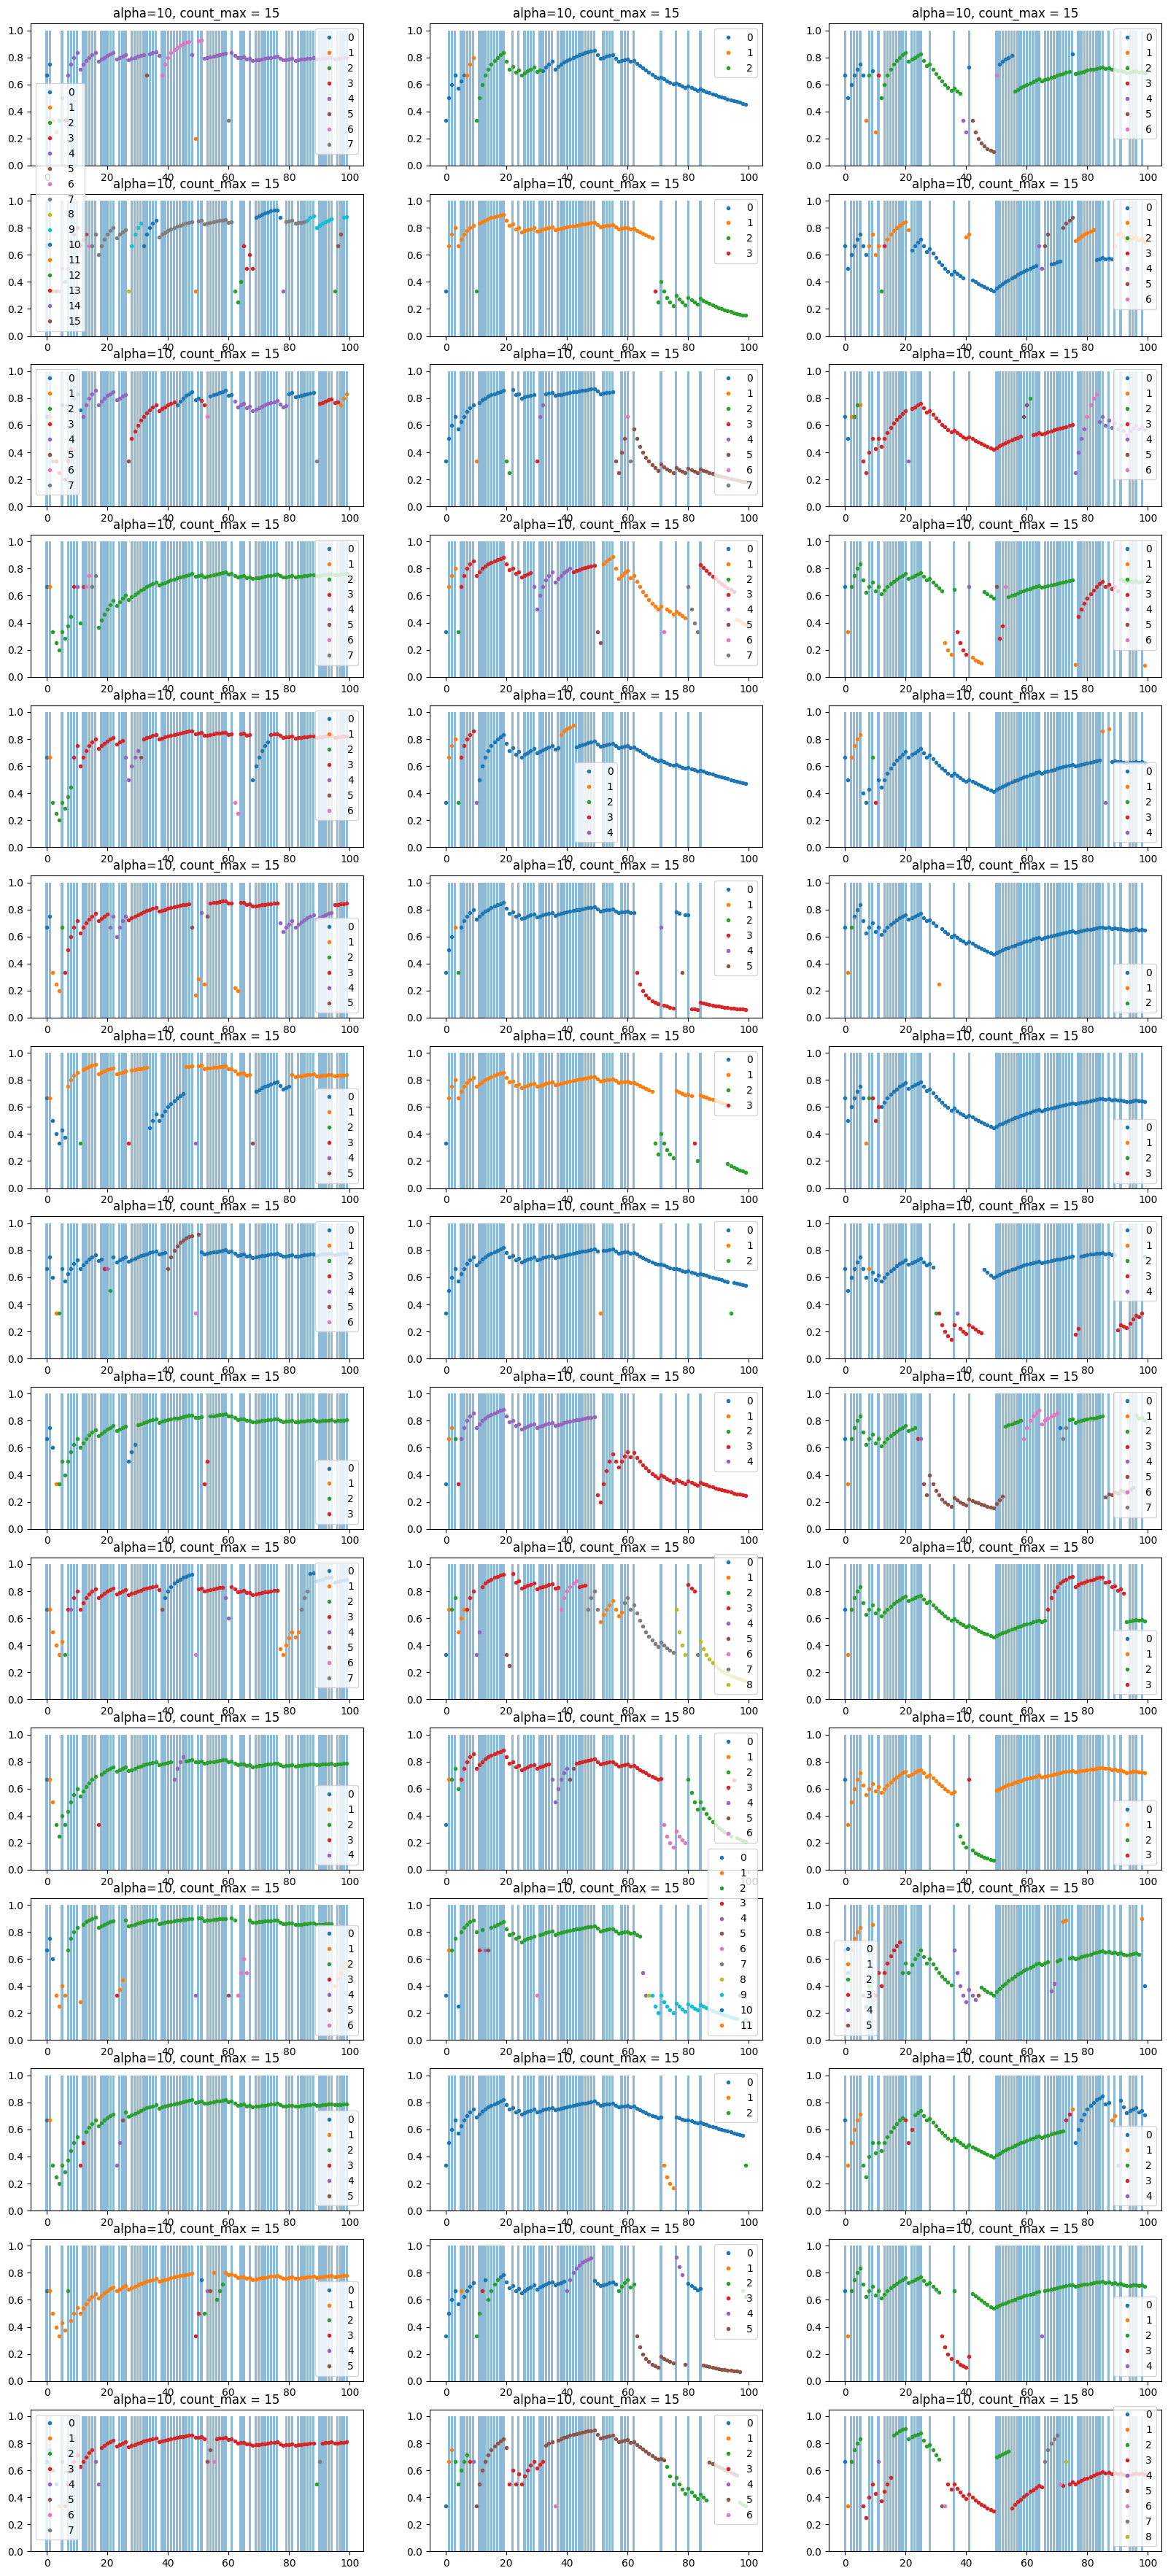

In [68]:
repeat = 15
plt.figure(figsize=(20,3 * repeat))

for r in range(repeat):
    for i, data in enumerate((data_1, data_2, data_4)):
    
        #beta_, count, mem_choice, mem_q = vol_dirichlet_change_detection(data, v=0.15, alpha = 10, count_max = 30)
        alpha = 10 # novelty bonus
        v = 0.15
        count_max = 15
        beta_, count, mem_choice, mem_q = vol_dirichlet_change_detection(data, v=v, alpha = alpha, count_max = count_max)
    
        ax = plt.subplot(repeat, 3, 3*r+i+1)
        ax.bar(range(len(data)),data, alpha=.5)
        for k in range(len(beta_)):
            axe = np.where(np.array(mem_choice) == k)[0]
            plt.plot(axe, np.array(mem_q)[axe],'.', label=k)
            plt.title(f'alpha={alpha}, count_max = {count_max}')
            '''plt.plot([0,24],[.75,.75],'r:')
            plt.plot([25,49],[.25,.25],'r:')
            plt.plot([50,74],[.9,.9],'r:')
            plt.plot([75,99],[.5,.5],'r:')'''
        ax.legend()

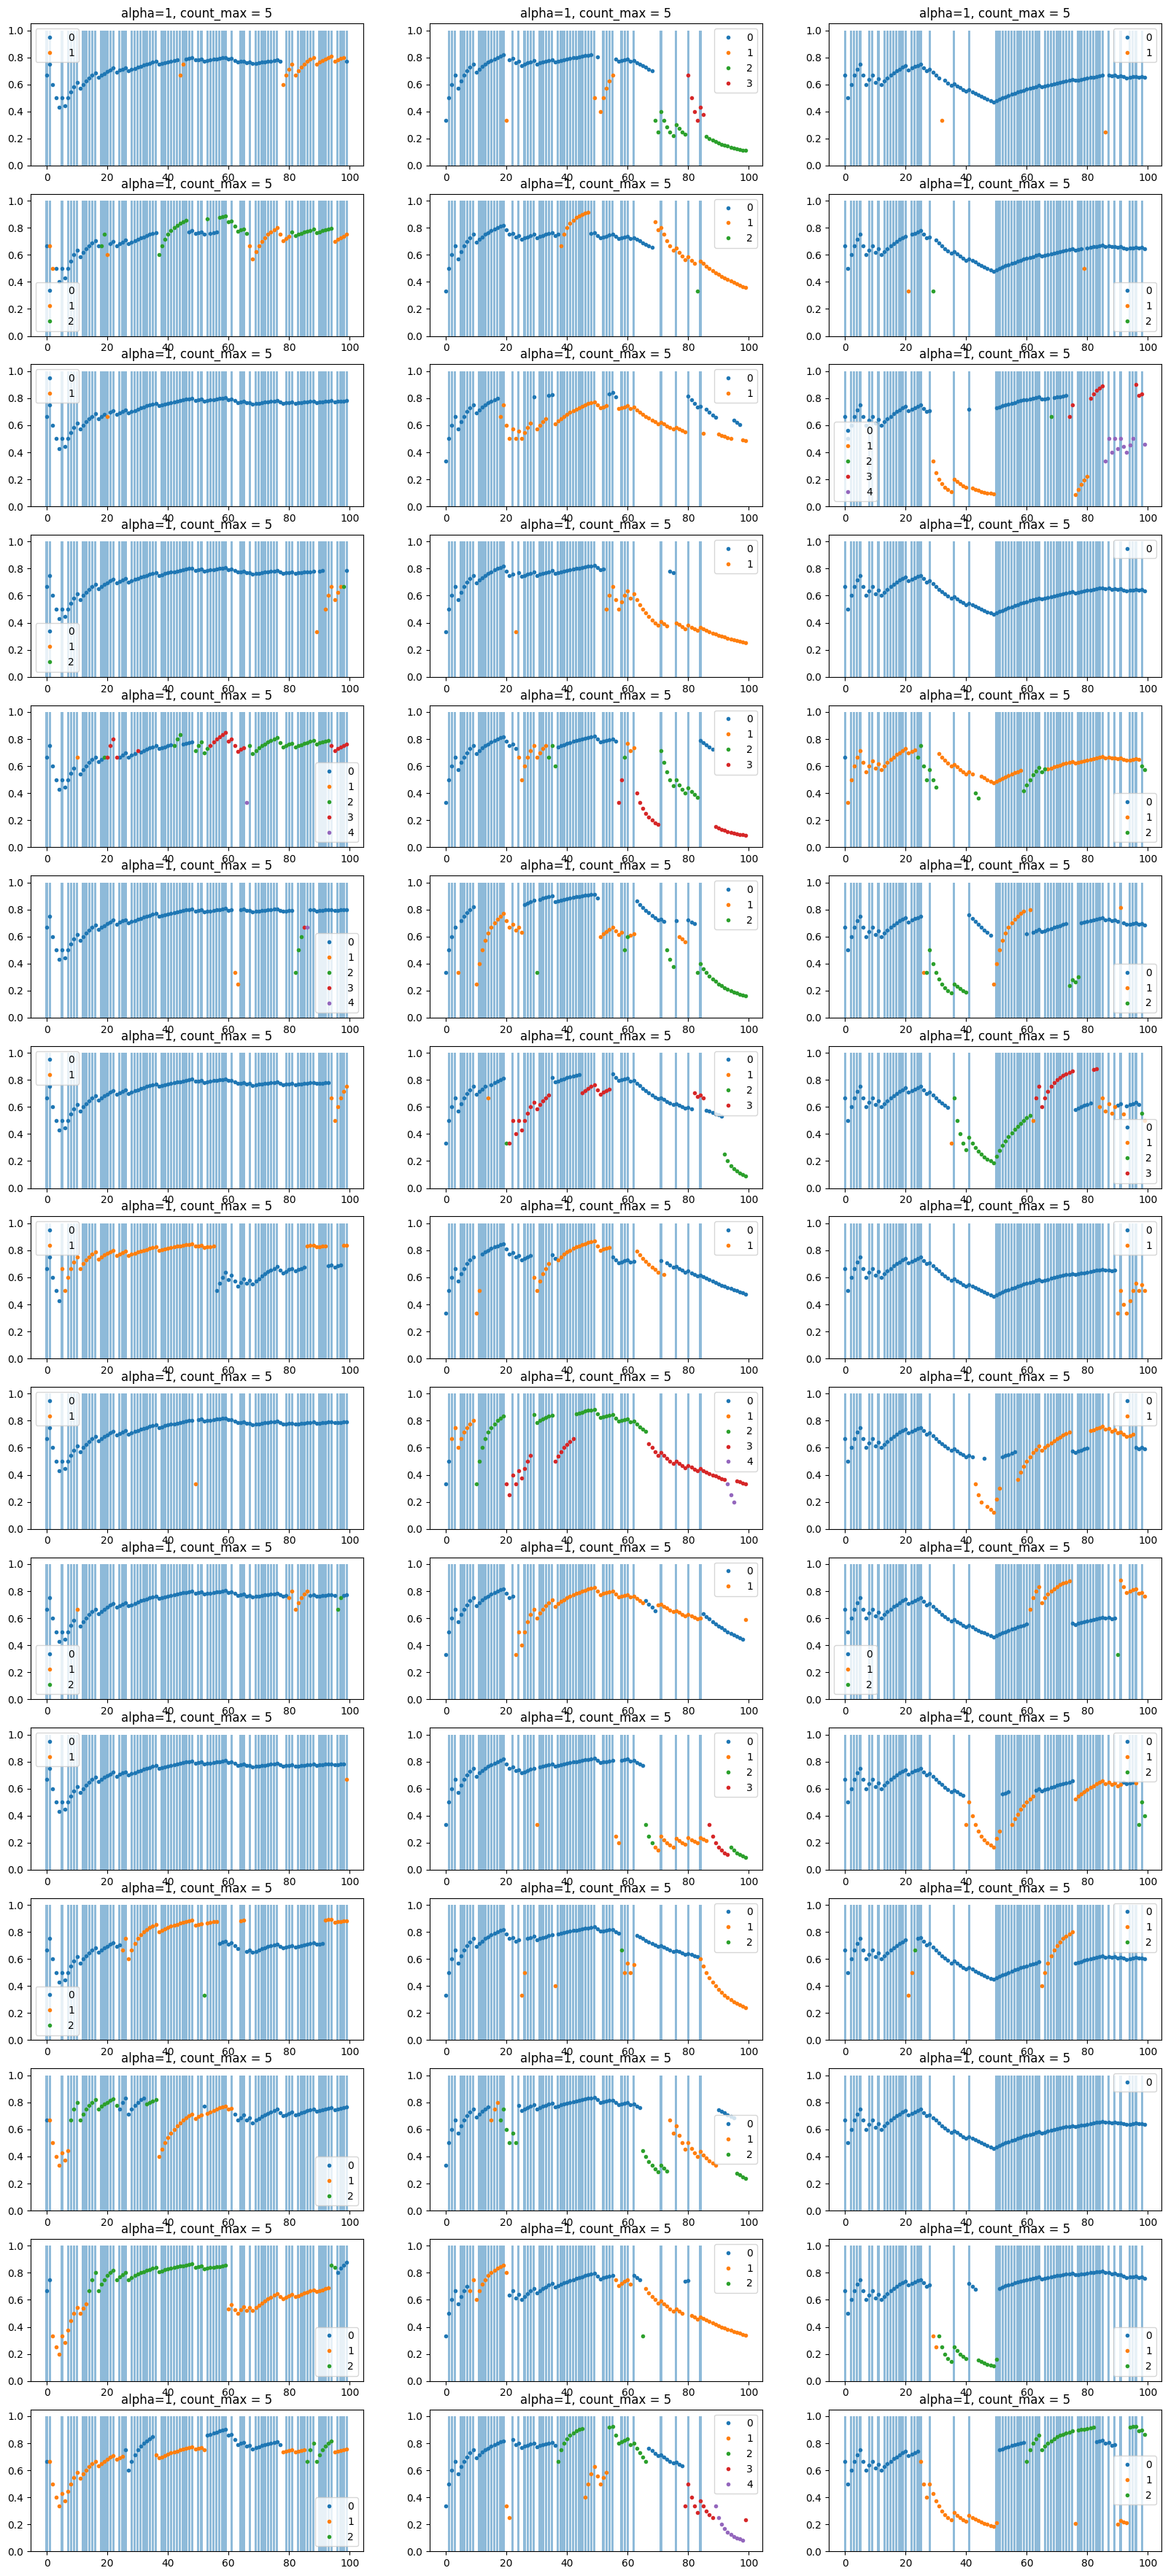

In [82]:
repeat = 15
plt.figure(figsize=(20,3 * repeat))

for r in range(repeat):
    for i, data in enumerate((data_1, data_2, data_4)):
    
        #beta_, count, mem_choice, mem_q = vol_dirichlet_change_detection(data, v=0.15, alpha = 10, count_max = 30)
        alpha = 1 # novelty bonus (régule le nb de nouveaux états)
        v = 0.2
        count_max = 5 #10 #15 # avantage d'usage (on ne prete qu'aux riches)
        beta_, count, mem_choice, mem_q = vol_dirichlet_change_detection(data, v=v, alpha = alpha, count_max = count_max)
    
        ax = plt.subplot(repeat, 3, 3*r+i+1)
        ax.bar(range(len(data)),data, alpha=.5)
        for k in range(len(beta_)):
            axe = np.where(np.array(mem_choice) == k)[0]
            plt.plot(axe, np.array(mem_q)[axe],'.', label=k)
            plt.title(f'alpha={alpha}, count_max = {count_max}')
            '''plt.plot([0,24],[.75,.75],'r:')
            plt.plot([25,49],[.25,.25],'r:')
            plt.plot([50,74],[.9,.9],'r:')
            plt.plot([75,99],[.5,.5],'r:')'''
        ax.legend()